# Code to view runoff onset maps

In [1]:
import adlfs
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import contextily as ctx
import odc.stac
import pathlib
import configparser
import shapely
import matplotlib.pyplot as plt

In [2]:
sas_token = pathlib.Path('sas_token.txt').read_text()

valid_tiles_gdf = gpd.read_file('valid_tiles.geojson')
valid_tiles_gdf = valid_tiles_gdf.sort_values(by='percent_valid_snow_pixels',ascending=False) 
#valid_tiles_gdf.explore(column='percent_valid_snow_pixels')

config = configparser.ConfigParser()

config.read('global_config.txt')
resolution = config.getfloat('VALUES', 'resolution')
zarr_chunk_size = (config.getint('VALUES', 'chunk_size'),config.getint('VALUES', 'chunk_size'))
bbox_left = config.getfloat('VALUES', 'bbox_left')
bbox_right = config.getfloat('VALUES', 'bbox_right')
bbox_top = config.getfloat('VALUES', 'bbox_top')
bbox_bottom = config.getfloat('VALUES', 'bbox_bottom')

WY_start = config.getint('VALUES', 'WY_start') 
WY_end = config.getint('VALUES', 'WY_end') 
water_years = np.arange(WY_start, WY_end + 1)

min_years_for_median_std = config.getint('VALUES', 'min_years_for_median_std')

min_monthly_acquisitions = config.getint('VALUES', 'min_monthly_acquisitions')
max_allowed_days_gap_per_orbit = config.getint('VALUES', 'max_allowed_days_gap_per_orbit')
low_backscatter_threshold = config.getfloat('VALUES', 'low_backscatter_threshold')

start_date = '2014-01-01'
today = pd.Timestamp.today().strftime('%Y-%m-%d')
end_date = today

print(f'Config loaded: \n{resolution=}, \n{zarr_chunk_size=}, \n{bbox_left=}, \n{bbox_right=}, \n{bbox_top=}, \n{bbox_bottom=}, \n{start_date=}, \n{end_date=} \n{water_years=}, \n{min_years_for_median_std=}, \n{low_backscatter_threshold=}, \n{min_monthly_acquisitions=}, \n{max_allowed_days_gap_per_orbit=}')

Config loaded: 
resolution=0.00072000072000072, 
zarr_chunk_size=(2048, 2048), 
bbox_left=-179.999, 
bbox_right=179.999, 
bbox_top=81.099, 
bbox_bottom=-59.999, 
start_date='2014-01-01', 
end_date='2024-10-15' 
water_years=array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]), 
min_years_for_median_std=3, 
low_backscatter_threshold=0.001, 
min_monthly_acquisitions=2, 
max_allowed_days_gap_per_orbit=30


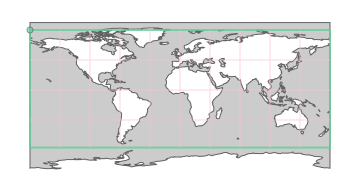

In [3]:
global_geobox = odc.geo.geobox.GeoBox.from_bbox((bbox_left, bbox_bottom,
   bbox_right, bbox_top),crs="epsg:4326", resolution=resolution)

geobox_tiles = odc.geo.geobox.GeoboxTiles(global_geobox,zarr_chunk_size)

global_geobox

In [4]:
class Tile:
    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.index = row,col
        self.percent_valid_snow_pixels = self.get_percent_valid_snow_pixels()
        self.geobox = self.get_geobox()
        self.bbox_gdf = self.get_bbox_gdf()
        self.start_time = None
        self.total_time = None
        self.s1_rtc_ds = None
        self.s1_rtc_ds_dims = None
        self.s1_rtc_masked_ds_dims = None
        self.runoff_onsets = None
        self.runoff_onsets_dims = None
        self.tr_2015 = None
        self.tr_2016 = None
        self.tr_2017 = None
        self.tr_2018 = None
        self.tr_2019 = None
        self.tr_2020 = None
        self.tr_2021 = None
        self.tr_2022 = None
        self.tr_2023 = None
        self.tr_2024 = None
        self.pix_ct_2015 = None
        self.pix_ct_2016 = None
        self.pix_ct_2017 = None
        self.pix_ct_2018 = None
        self.pix_ct_2019 = None
        self.pix_ct_2020 = None
        self.pix_ct_2021 = None
        self.pix_ct_2022 = None
        self.pix_ct_2023 = None
        self.pix_ct_2024 = None
        self.error_messages = []
        self.success = False

    
    def get_geobox(self):
        return geobox_tiles[self.index]
    
    def get_bbox_gdf(self):
        bbox = self.geobox.boundingbox
        bbox_geometry = shapely.geometry.box(bbox.left, bbox.bottom, bbox.right, bbox.top)
        bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geometry], crs=self.geobox.crs)
        return bbox_gdf
    
    def get_percent_valid_snow_pixels(self):
        return float(valid_tiles_gdf['percent_valid_snow_pixels'].loc[(valid_tiles_gdf['row'] == self.row) & (valid_tiles_gdf['col'] == self.col)].values[0])
    
    def get_info(self):
        return f"Processing Tile {self.index}"

In [5]:
valid_tiles_gdf = gpd.read_file('valid_tiles.geojson')
valid_tiles_gdf = valid_tiles_gdf.sort_values(by='percent_valid_snow_pixels',ascending=False) 

global_geobox = odc.geo.geobox.GeoBox.from_bbox((bbox_left, bbox_bottom,
   bbox_right, bbox_top),crs="epsg:4326", resolution=resolution)

geobox_tiles = odc.geo.geobox.GeoboxTiles(global_geobox,zarr_chunk_size)

tiles = [Tile(row,col) for row,col in zip(valid_tiles_gdf.row,valid_tiles_gdf.col)]

processed_tiles_df = pd.read_csv('tile_results.csv')
processed_tiles_df = processed_tiles_df[processed_tiles_df['success'] == True]
processed_tiles = set(zip(processed_tiles_df['row'], processed_tiles_df['col']))


tiles = [tile for tile in tiles if (tile.row, tile.col) in processed_tiles]

In [6]:
all_tiles = valid_tiles_gdf.merge(processed_tiles_df[['row', 'col']], on=['row', 'col'], how='left', indicator=True)
all_tiles['status'] = np.where(all_tiles['_merge'] == 'both', 'Processed', 'Unprocessed')
all_tiles = all_tiles.drop('_merge', axis=1)

m = all_tiles[all_tiles['status'] == 'Processed'].explore(column='percent_valid_snow_pixels')
all_tiles[all_tiles['status'] == 'Unprocessed'].explore(m=m,column='status',cmap=['grey','black'],legend=True)

In [7]:
global_store = adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token).get_mapper("snowmelt/snowmelt_runoff_onset/global.zarr")
global_ds = xr.open_zarr(global_store, consolidated=True,decode_coords='all')

def view_tile(tile: Tile):


    test_ds = global_ds.rio.clip_box(*tile.get_geobox().boundingbox,crs='EPSG:4326')
    test_ds = test_ds.rio.reproject(test_ds.rio.estimate_utm_crs())

    f,axs=plt.subplots(1,2,figsize=(10,5))
    test_ds['runoff_onset_median'].plot.imshow(ax=axs[0],vmin=0,vmax=365)
    axs[0].set_title('2015-2024 median snowmelt runoff onset')

    test_ds['runoff_onset_std'].plot.imshow(ax=axs[1],cmap='Reds',vmin=0,vmax=60)
    axs[1].set_title('2015-2024 std deviation snowmelt runoff onset')

    for ax in axs:
        ax.set_aspect('equal')
        ctx.add_basemap(ax=ax, crs=test_ds.rio.crs.to_string())

    f.tight_layout()

    test_ds['runoff_onset'].plot.imshow(col='water_year',col_wrap=5,vmin=0,vmax=365)

    (test_ds['runoff_onset']-test_ds['runoff_onset_median']).plot.imshow(col='water_year',col_wrap=5,vmin=-60,vmax=60,cmap='RdBu')

In [8]:
#view_tile(Tile(23,129))

In [9]:
global_ds

<xarray.Dataset> Size: 5TB
Dimensions:              (latitude: 195970, longitude: 499998, water_year: 10)
Coordinates:
  * latitude             (latitude) float64 2MB 81.1 81.1 81.1 ... -60.0 -60.0
  * longitude            (longitude) float64 4MB -180.0 -180.0 ... 180.0 180.0
    spatial_ref          int32 4B ...
  * water_year           (water_year) int64 80B 2015 2016 2017 ... 2023 2024
Data variables:
    runoff_onset         (water_year, latitude, longitude) float32 4TB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    runoff_onset_median  (latitude, longitude) float32 392GB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    runoff_onset_std     (latitude, longitude) float32 392GB dask.array<chunksize=(2048, 2048), meta=np.ndarray>
Attributes:
    processed_tiles:  []

In [10]:
test_ds = global_ds.rio.clip_box(-120,30,-110,50,crs='EPSG:4326')
test_ds

<xarray.Dataset> Size: 19GB
Dimensions:              (latitude: 27779, longitude: 13890, water_year: 10)
Coordinates:
  * latitude             (latitude) float64 222kB 50.0 50.0 50.0 ... 30.0 30.0
  * longitude            (longitude) float64 111kB -120.0 -120.0 ... -110.0
  * water_year           (water_year) int64 80B 2015 2016 2017 ... 2023 2024
    spatial_ref          int64 8B 0
Data variables:
    runoff_onset         (water_year, latitude, longitude) float32 15GB dask.array<chunksize=(1, 1863, 636), meta=np.ndarray>
    runoff_onset_median  (latitude, longitude) float32 2GB dask.array<chunksize=(1863, 636), meta=np.ndarray>
    runoff_onset_std     (latitude, longitude) float32 2GB dask.array<chunksize=(1863, 636), meta=np.ndarray>
Attributes:
    processed_tiles:  []

In [ ]:
f,axs=plt.subplots(1,2,figsize=(10,10))
test_ds['runoff_onset_median'].plot.imshow(ax=axs[0],vmin=0,vmax=365)
test_ds['runoff_onset_std'].plot.imshow(ax=axs[1],cmap='Reds')

for ax in axs:
    ctx.add_basemap(ax, crs=test_ds.rio.crs.to_string())

In [ ]:
test_ds['runoff_onset'].plot.imshow(col='water_year',col_wrap=3,vmin=0,vmax=365)